In [7]:
from dataclasses import dataclass
import xarray as xr
import rioxarray as xrr
from rioxarray.merge import merge_arrays
import geopandas as gpd
import contextily as cx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles as cimgt
from shapely.geometry import box
import seaborn as sns

import make_slr_scenario as make_SS

%matplotlib inline
%pdb off

print (os.getenv('CONDA_PROMPT_MODIFIER'), datetime.now())

Automatic pdb calling has been turned OFF
(SL)  2024-10-23 12:04:58.502955


# Setup 

In [2]:
path_wd = Path('/scratch/tws_grace/data/Sea_Level/SFEI')
use_vlm = True
# path_wd = Path('/Volumes/RADS/NFS/data/Sea_Level/SFEI')

In [3]:
regions = 'South Central North'.split()
# scen = scen0.replace('_rsl', '')
# s2_ext = '_s2' if use_s2 else ''
# vlm_ext = '_vlm' if use_vlm else ''

basemap_d = cimgt.GoogleTiles(url='https://server.arcgisonline.com/ArcGIS/rest/services/Elevation/World_Hillshade_Dark/MapServer/tile/{z}/{y}/{x}.jpg')
basemap   = cimgt.GoogleTiles(url='https://server.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg')
# basemap   = cimgt.GoogleTiles(url='https://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}'))

cxbasemap   = cx.providers.Esri.WorldImagery
cxbasemap_d = cx.providers.CartoDB.DarkMatter
cxbasemap_t = cx.providers.USGS.USTopo
            
projp = ccrs.PlateCarree()
GFS = GS  = 14 
TFS = 20 # title
XFS = YFS = 16 # x/y axis
GFS = 14 # deg marks
CFS = 18 # colorbar labels

pt_parms  = dict(verticalalignment='top', fontsize=20, color='w',
                bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))

dct_proju = {'Central': ccrs.UTM(10), 'North': ccrs.UTM(10), 'South': ccrs.UTM(11)}

sty_cari   = dict(facecolor='none', edgecolor='deeppink') 

In [4]:
def create_results(gdf_in, units_in='mi2', kind='lost', show=True):
    """ Create the dataframe of total area lost/gain and pct area lost for each region and total """
    assert kind in 'lost gain'.split(), 'Choose lost or gained'
    assert units_in in 'm2 km2 mi2'.split(), f'Incorrect units: {units_in}'
    ## create dataframe with overall numbers
    scale = dct_units2[units_in]
    fmt = '.2e' if units_in == 'm2' else '.2f'
    
    lst_res = []
    for reg, gdf_reg in gdf_in.groupby('region'):
        if show:
            print (f'{reg}:')
        for scen, gdf_scen in gdf_reg.groupby('scenario'):
            area_tot = gdf_scen['area'].sum()
            area_chg = gdf_scen[f'area_{kind}'].sum()
            pct_chg = 100 * (area_chg / area_tot)
            if show:
                print (f'\t{scen}: {kind.title()} {area_chg*scale:{fmt}} {units_in} of {area_tot*scale:{fmt}} {units_in}  ({pct_chg:.2f})%')
            lst_res.append([reg, scen, area_tot, area_chg, pct_chg])
    
    ## numbers for total
    if show:
        print ('Total:')
    for scen, gdf_scen in gdf_in.groupby('scenario'):
        area_tot = gdf_scen['area'].sum()
        area_chg = gdf_scen[f'area_{kind}'].sum()
        pct_chg = 100 * (area_chg/ area_tot)
        if show:
            print (f'\t{scen}: {kind.title()} {area_chg*scale:{fmt}} {units_in} of {area_tot*scale:{fmt}} {units_in}  ({pct_chg:.2f})%')
        lst_res.append(['Total', scen, area_tot, area_chg, pct_chg])
        
    df_res = pd.DataFrame(lst_res, columns=f'region scenario area_total area_{kind} pct_{kind}'.split())
    df_res[f'area_{kind}_mi2'] = df_res[f'area_{kind}'] * dct_units2['mi2']
    df_res[f'area_{kind}_km2'] = df_res[f'area_{kind}'] * dct_units2['km2']
    df_res.sort_values(by='region', key=lambda x: x.map({**region_mapping, 'Total': 3}), inplace=True)
    return df_res.sort_values(by='scenario', key=lambda x: x.map(scen_mapping))

In [11]:
def plot_area_pct1(df_results, year, hab='Beach', kind='lost', area_pct='area', show_units='km2', ylims=[0, 23]):
    hab, area_pct = hab.title(), area_pct.lower()
    assert hab in 'Beach Rocky'.split(), 'hab should be beach or rocky'
    assert area_pct in 'area pct'.split(), 'area_pct should be area or pct'
    if area_pct == 'pct':
        show_units = '%'
        unit_col = ''
        lbl_ext = '_pct'
    else:
        unit_col = '' if show_units == 'm2' else f'_{show_units}'
        show_units = f'{show_units[:-1]}$^2$'
        lbl_ext = ''
    
    fig, axes = plt.subplots(figsize=(10, 4))
    bp = sns.barplot(data=df_results, x='scenario', y=f'{area_pct}_{kind}{unit_col}', hue='region', palette=colors, ax=axes, errorbar=None, gap=0.1)
    bp.legend().set_title('')
    axes.set_xlabel('')
    axes.grid(color='k', linestyle='--', alpha=0.1)
    axes.set_ylabel(f'{hab} {kind.title()} ({show_units})', fontsize=XFS);
    axes.tick_params(axis='both', which='major', labelsize=12)
    axes.set_ylim(ylims)
    plt.legend(fontsize=14, ncols=2)
    [axes.bar_label(container, fmt="{:.1f}", rotation=90, fontsize=13, padding=5) for container in axes.containers]
    fig.set_label(f'{hab.lower()}_{year}_{kind}{lbl_ext}')
    axes.set_title(year, fontsize=TFS)
    return fig, axes


def plot_area_pct2(dfs, hab='Beach', kind='lost', area_pct='area', show_units='km2', ylims=[0, 100]):
    """ Plot the 2050 and 2100 datasets together """
    hab, area_pct = hab.title(), area_pct.lower()
    assert len(dfs) == 2, 'Give 2050 and 2100 df'
    assert hab in 'Beach Rocky'.split(), 'hab should be beach or rocky'
    assert area_pct in 'area pct'.split(), 'area_pct should be area or pct'
    df_2050, df_2100 = dfs
    if area_pct == 'pct':
        show_units = '%'
        unit_col = ''
        lbl_ext = '_pct'
    else:
        unit_col = '' if show_units == 'm2' else f'_{show_units}'
        show_units = f'{show_units[:-1]}$^2$'
        lbl_ext = ''
    
    fig, (axe1, axe2) = plt.subplots(figsize=(10, 6), nrows=2, sharex=True)
    bp1 = sns.barplot(data=df_2050, x='scenario', y=f'{area_pct}_{kind}{unit_col}', 
                      hue='region', palette=colors, ax=axe1, errorbar=None, gap=0.1)
    bp2 = sns.barplot(data=df_2100, x='scenario', y=f'{area_pct}_{kind}{unit_col}', 
                      hue='region', palette=colors, ax=axe2, errorbar=None, gap=0.1)
    axe1.set_xlabel('')
    
    for ax, year in zip([axe1, axe2], (2050, 2100)):
        ax.legend().set_visible(False)
        ax.grid(color='k', linestyle='--', alpha=0.1)
        ax.set_ylabel(f'{hab} {kind.title()} ({show_units})', fontsize=XFS);
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_ylim(ylims)
        ax.set_xlabel('')
        ax.text(0.02, 0.85, year, fontsize=18, transform=ax.transAxes, color='w', bbox=dict(boxstyle='square,pad=0.05', facecolor='black'))
        [ax.bar_label(container, fmt="{:.1f}", rotation=90, fontsize=12, padding=-5, color='blue') for container in ax.containers]
        
    h, l = ax.get_legend_handles_labels()
    fig.legend(handles=h, labels=l, ncol=4, bbox_to_anchor=(0.795, 0.535), fontsize=13)
    fig.subplots_adjust(hspace=0.25)
    fig.set_label(f'{hab.lower()}_{kind}{lbl_ext}')
    return fig, (axe1, axe2)

# Plot MLLW / MAH

In [8]:
from BZ import bbPlot
kind, scen, year = 'MLLW', 'Int', 2050
da_mllw0 =  xrr.open_rasterio(path_wd / 'tidal_datums' / f'{kind}_SLR_0.tif').squeeze()
da_mllw_slr =  xrr.open_rasterio(path_wd / 'tidal_datums' / f'{kind}_SLR_{scen}{year}_VLM.tif').squeeze()
sty_mllw = dict(cmap='cmc.vik', norm=mpl.colors.TwoSlopeNorm(0, -0.4, 0.4), shading='nearest', transform=projp)
# w, s, e, n = da_mllw0.rio.bounds()

In [15]:
# get one dummy for the bounds
gdf_res = gpd.read_file(path_wd / 'results' / f'beach_polygons_lost_{year}.GeoJSON')

In [17]:
dct_reg_box = {}
for region in regions:
    gdf_reg = gdf_res[gdf_res['region'] == region]
    dct_reg_box[region] =  gpd.GeoSeries(box(*gdf_reg.total_bounds), crs=4326)

In [34]:
fig, axes = plt.subplots(figsize=(10, 14), ncols=2, subplot_kw={'projection': projp})
for i, da in enumerate([da_mllw0, da_mllw_slr]):
    da = da.rio.reproject(4326).copy()
    da = da.where(da<1e10)
    da.rio.write_nodata(da.rio.nodata, encoded=True, inplace=True)
    axes[i].add_image(basemap, 10)
    im = axes[i].pcolormesh(da.x, da.y, da, **sty_mllw)
    cbar = bbPlot.cartopy_cbar(im, xlabel=('m', GS))
    cbar.ax.set_visible(False) if i == 0 else ''
    # left = True if i ==0 else False
    # gl = axes[i].gridlines(draw_labels=True)
    # bbPlot.fmt_gridlines(gl, left=left, bottom=True, size=GS)

    ## add the regional boundaries 
    colors = plt.cm.get_cmap('cmo.matter')
    colors = [colors(0.0), colors(0.25), colors(0.5)]

## otherwise basemap gets overwritten... dunno why
for j, (reg, gdf_reg) in enumerate(dct_reg_box.items()):
    for ax in axes:
        gdf_reg.plot(ax=ax, facecolor='none', edgecolor=colors[j], 
                 linestyle='--', linewidth=2.25, zorder=50)

fig.subplots_adjust(wspace=0.0)
fig.set_label(f'MLLW0_MLLW{scen}{year}')
bbPlot.savefigs(path_wd, True, True)

INFO:   savefigs:1211   [Oct 22, 12:11:50] Saved figure: /scratch/tws_grace/data/Sea_Level/SFEI/Figures/MLLW0_MLLWInt2050.png


# Plot SLR Scenario and VLM
- To check they make sense

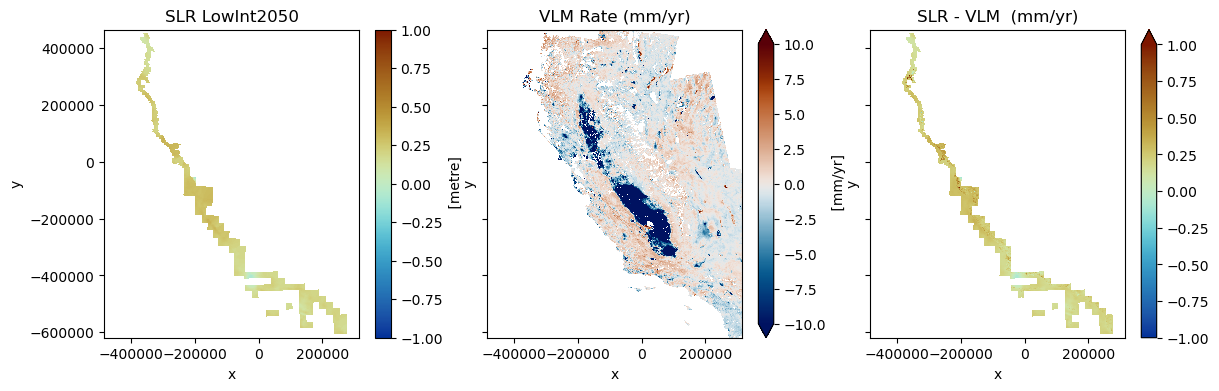

In [4]:
scen1 = 'LowInt2050'
sty_slr = dict(cmap='cmc.roma_r', norm=mpl.colors.Normalize(-1, 1))
sty_vlm = dict(cmap='cmc.vik', norm=mpl.colors.Normalize(-10, 10))

da_slr = xrr.open_rasterio(path_wd / 'tidal_datums' / 'MLLW_SLR_Int2050.tif').sel(band=1)
da_vlm = xrr.open_rasterio(path_wd / 'CA_VLM_MLLW.tif').sel(band=1).assign_attrs(units='mm/yr')
da_vlm = da_vlm.where(da_vlm < 1e20)
da_vlm_2050 = da_vlm * 26 / 1000
da_tot = da_slr - da_vlm_2050.where(~da_vlm.isnull(), 0)

fig, axes = plt.subplots(figsize=(14, 4), ncols=3, sharey=True)
da_slr.plot(ax=axes[0], **sty_slr)
da_vlm.plot(ax=axes[1], **sty_vlm)
da_tot.plot(ax=axes[2], **sty_slr)
axes[0].set_title(f'SLR {scen1}')
axes[1].set_title(f'VLM Rate (mm/yr)');
axes[2].set_title(f'SLR - VLM  (mm/yr)');

# da_resid.plot(ax=axes[2], cmap='cmc.vik', norm=mpl.colors.TwoSlopeNorm(0))


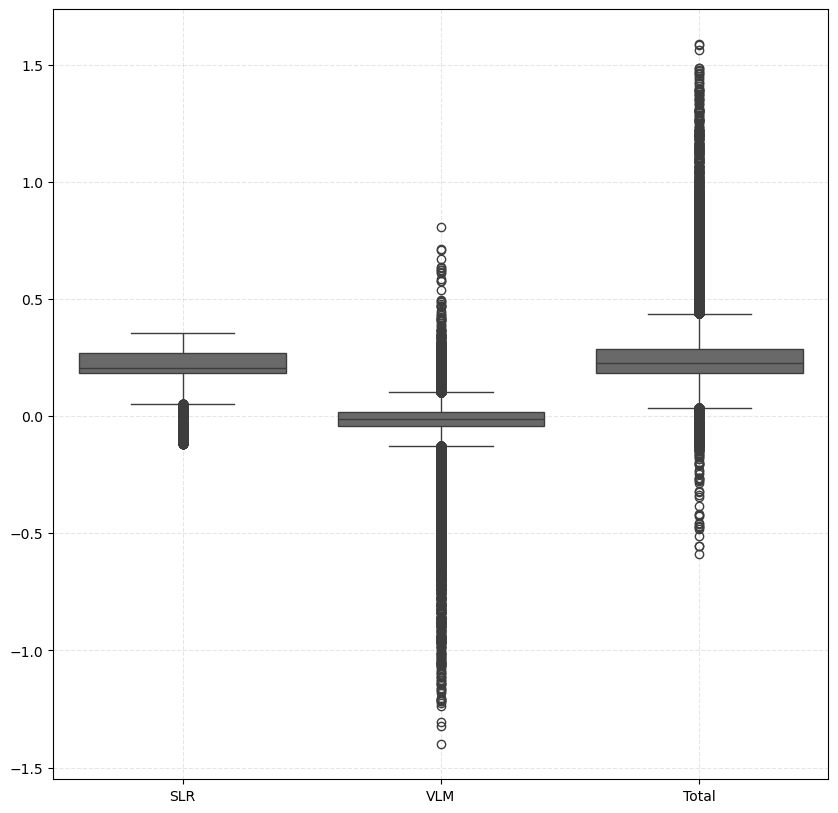

In [31]:
from BZ import da_mmm
fig, axes = plt.subplots(figsize=(10, 10))

df = pd.DataFrame({'SLR': da_slr.data.ravel(), 'VLM': da_vlm_2050.data.ravel(), 'Total': da_tot.data.ravel()}).dropna()

sns.boxplot(ax=axes, data=df, color='dimgray')
axes.grid(color='k', alpha=0.1, linestyle='--')

print ('Total Numbers:')
da_mmm(da_tot)

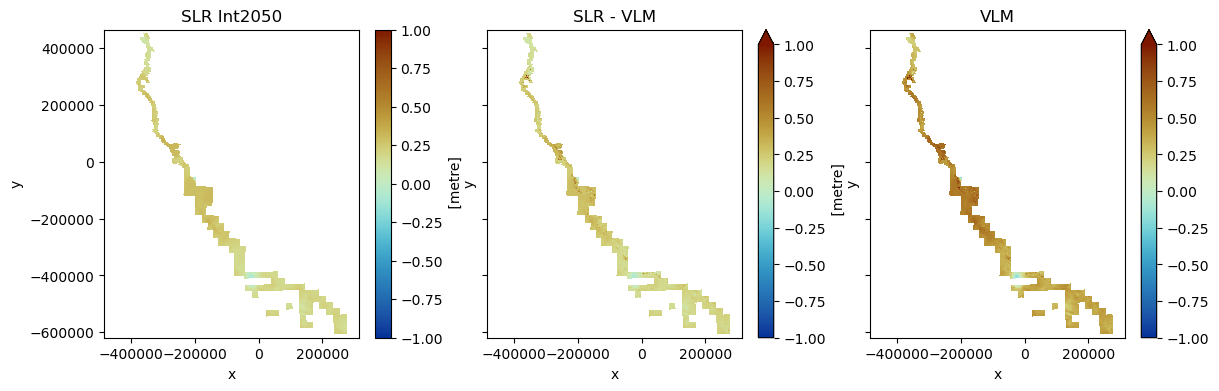

In [9]:
## load the newly created total
scen1 = 'Int2050'
sty_slr = dict(cmap='cmc.roma_r', norm=mpl.colors.Normalize(-1, 1))
sty_vlm = dict(cmap='cmc.vik', norm=mpl.colors.Normalize(-1, 1))

da_slr = xrr.open_rasterio(path_wd / 'tidal_datums' / 'MLLW_SLR_Int2050.tif').sel(band=1)
da_tot = xrr.open_rasterio(path_wd / 'tidal_datums' / 'MLLW_SLR_Int2050_VLM.tif').sel(band=1)
da_vlm = da_tot + da_slr

fig, axes = plt.subplots(figsize=(14, 4), ncols=3, sharey=True)
da_slr.plot(ax=axes[0], **sty_slr)
da_tot.plot(ax=axes[1], **sty_slr)
da_vlm.plot(ax=axes[2], **sty_slr)
axes[0].set_title(f'SLR {scen1}')
axes[1].set_title(f'SLR - VLM')
axes[2].set_title(f'VLM');

# da_resid.plot(ax=axes[2], cmap='cmc.vik', norm=mpl.colors.TwoSlopeNorm(0))


# Plot Overall Results

In [8]:
from BZ.bbPlot import savefigs
vlm_ext = '_vlm' if use_vlm else ''
dct_units2 = {'m2': 1, 'km2': 1e-6, 'mi2': 3.86102e-7} # conversion factors from m2
## sort by region and then scenario?
region_mapping = {'South': 0, 'Central': 1, 'North': 2}
scen_mapping = {'Low': 0, 'IntLow': 1, 'Int': 2, 'IntHigh': 3, 'High': 4}

colors = plt.cm.get_cmap('cmo.matter')
colors = [colors(0.0), colors(0.25), colors(0.5), 'gray'] # South Central North Total

## Beach

In [9]:
print ('Beaches 2050')
gdf_b = gpd.read_file(path_wd / 'results' / f'beach_polygons_lost_2050{vlm_ext}.GeoJSON')
gdf_b['scen_yr'] = gdf_b.apply(lambda x: f'{x["scenario"]}$_{{{str(x["year"])[-2:]}}}$', axis=1)
df_beach_loss2050 = create_results(gdf_b, 'km2', show=True)

print ('\nBeaches 2100')
gdf_b = gpd.read_file(path_wd / 'results' / f'beach_polygons_lost_2100{vlm_ext}.GeoJSON')
gdf_b['scen_yr'] = gdf_b.apply(lambda x: f'{x["scenario"]}$_{{{str(x["year"])[-2:]}}}$', axis=1)
df_beach_loss2100 = create_results(gdf_b, 'km2', show=True)

Beaches 2050
Central:
	High: Lost 5.44 km2 of 25.86 km2  (21.04)%
	Int: Lost 3.78 km2 of 25.86 km2  (14.61)%
	IntHigh: Lost 4.65 km2 of 25.86 km2  (18.00)%
	IntLow: Lost 3.24 km2 of 25.86 km2  (12.53)%
	Low: Lost 2.63 km2 of 25.86 km2  (10.15)%
North:
	High: Lost 8.53 km2 of 34.43 km2  (24.76)%
	Int: Lost 7.01 km2 of 34.43 km2  (20.37)%
	IntHigh: Lost 7.79 km2 of 34.43 km2  (22.61)%
	IntLow: Lost 6.55 km2 of 34.43 km2  (19.01)%
	Low: Lost 6.04 km2 of 34.43 km2  (17.55)%
South:
	High: Lost 5.14 km2 of 26.35 km2  (19.51)%
	Int: Lost 3.27 km2 of 26.35 km2  (12.39)%
	IntHigh: Lost 4.25 km2 of 26.35 km2  (16.12)%
	IntLow: Lost 2.67 km2 of 26.35 km2  (10.13)%
	Low: Lost 2.02 km2 of 26.35 km2  (7.68)%
Total:
	High: Lost 19.11 km2 of 86.64 km2  (22.06)%
	Int: Lost 14.06 km2 of 86.64 km2  (16.22)%
	IntHigh: Lost 16.69 km2 of 86.64 km2  (19.26)%
	IntLow: Lost 12.46 km2 of 86.64 km2  (14.38)%
	Low: Lost 10.69 km2 of 86.64 km2  (12.34)%

Beaches 2100
Central:
	High: Lost 15.14 km2 of 25.86 km2  (5

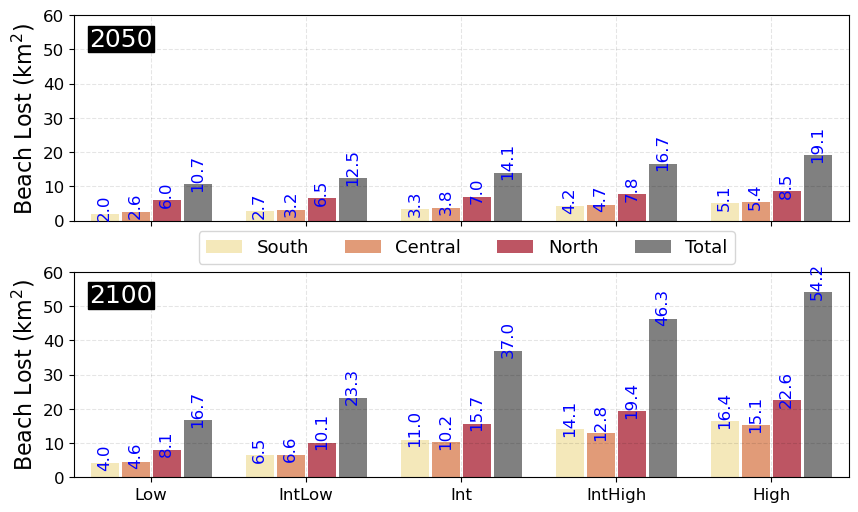

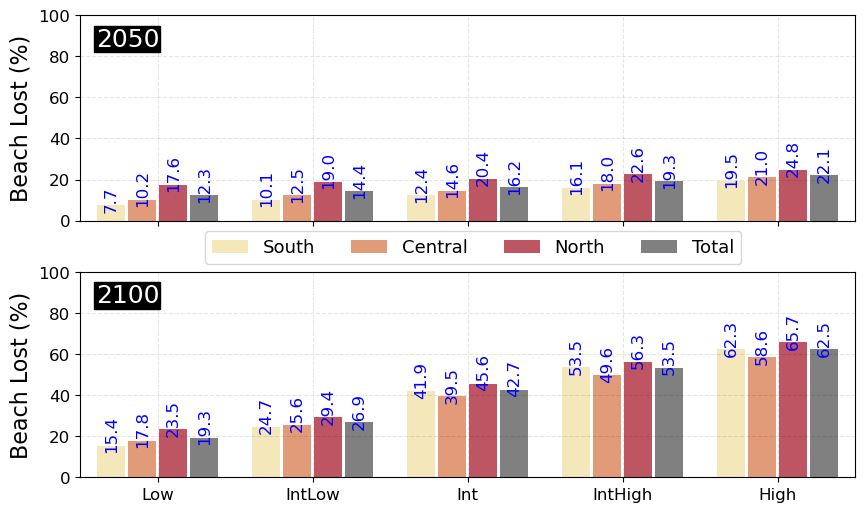

In [12]:
plot_area_pct2([df_beach_loss2050, df_beach_loss2100], 'Beach', ylims=[0, 60]);
plot_area_pct2([df_beach_loss2050, df_beach_loss2100], 'Beach', area_pct='pct', ylims=[0, 100]);
# savefigs(path_wd, True, True)

In [13]:
df1 = df_beach_loss2100
ser_area = df1[df1['region'] == 'Total']['area_lost_km2']
ser_pct = df1[df1['region'] == 'Total']['pct_lost']

print (f'AREA: Min | Mean+/-Std | Max: {ser_area.min():.1f}, {ser_area.mean():.1f} +/- {ser_area.std():.1f} | {ser_area.max():.1f} km2')
print (f'PCT: Min | Mean+/-Std | Max: {ser_pct.min():.1f}, {ser_pct.mean():.1f} +/- {ser_pct.std():.1f} | {ser_pct.max():.1f} %')

AREA: Min | Mean+/-Std | Max: 16.7, 35.5 +/- 15.6 | 54.2 km2
PCT: Min | Mean+/-Std | Max: 19.3, 41.0 +/- 18.0 | 62.5 %


## Rocky

In [14]:
gdf_r2050 = gpd.read_file(path_wd / 'results' / f'rocky_polygons_lost_2050{vlm_ext}.GeoJSON')
gdf_r2050['scen_yr'] = gdf_r2050.apply(lambda x: f'{x["scenario"]}$_{{{str(x["year"])[-2:]}}}$', axis=1)
df_rocky_loss2050 = create_results(gdf_r2050, 'km2', show=True)

gdf_r2100 = gpd.read_file(path_wd / 'results' / f'rocky_polygons_lost_2100{vlm_ext}.GeoJSON')
gdf_r2100['scen_yr'] = gdf_r2100.apply(lambda x: f'{x["scenario"]}$_{{{str(x["year"])[-2:]}}}$', axis=1)
df_rocky_loss2100 = create_results(gdf_r2100, 'km2', show=True)

Central:
	High: Lost 4.00 km2 of 11.94 km2  (33.51)%
	Int: Lost 2.73 km2 of 11.94 km2  (22.87)%
	IntHigh: Lost 3.41 km2 of 11.94 km2  (28.55)%
	IntLow: Lost 2.30 km2 of 11.94 km2  (19.28)%
	Low: Lost 1.81 km2 of 11.94 km2  (15.17)%
North:
	High: Lost 7.26 km2 of 10.91 km2  (66.55)%
	Int: Lost 6.94 km2 of 10.91 km2  (63.61)%
	IntHigh: Lost 7.11 km2 of 10.91 km2  (65.18)%
	IntLow: Lost 6.82 km2 of 10.91 km2  (62.54)%
	Low: Lost 6.69 km2 of 10.91 km2  (61.36)%
South:
	High: Lost 1.66 km2 of 4.90 km2  (33.96)%
	Int: Lost 1.12 km2 of 4.90 km2  (22.87)%
	IntHigh: Lost 1.41 km2 of 4.90 km2  (28.87)%
	IntLow: Lost 0.92 km2 of 4.90 km2  (18.87)%
	Low: Lost 0.70 km2 of 4.90 km2  (14.26)%
Total:
	High: Lost 12.93 km2 of 27.75 km2  (46.58)%
	Int: Lost 10.79 km2 of 27.75 km2  (38.89)%
	IntHigh: Lost 11.93 km2 of 27.75 km2  (43.00)%
	IntLow: Lost 10.05 km2 of 27.75 km2  (36.21)%
	Low: Lost 9.20 km2 of 27.75 km2  (33.17)%
Central:
	High: Lost 10.86 km2 of 11.94 km2  (90.95)%
	Int: Lost 8.15 km2 of 11

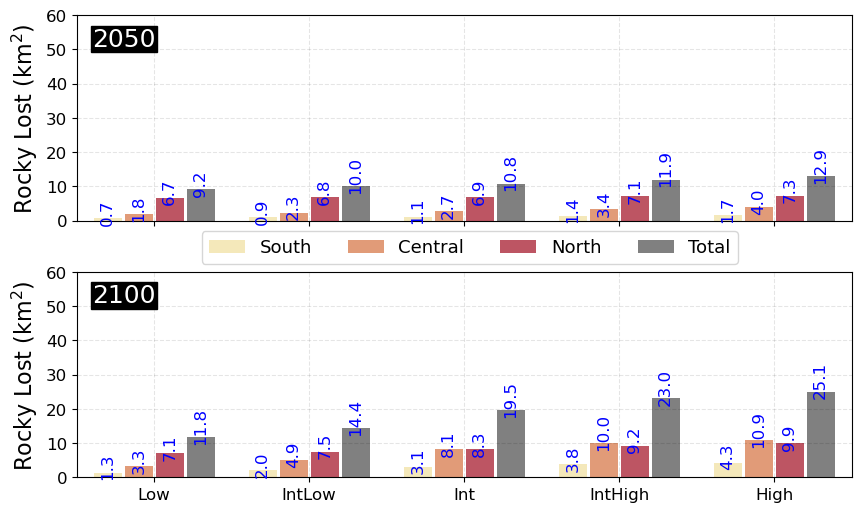

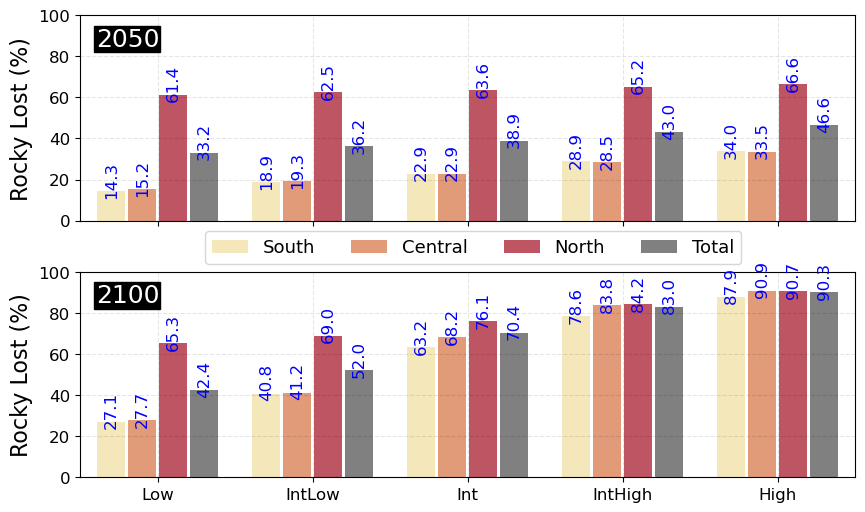

In [15]:
plot_area_pct2([df_rocky_loss2050, df_rocky_loss2100], 'Rocky', ylims=[0, 60]);
plot_area_pct2([df_rocky_loss2050, df_rocky_loss2100], 'Rocky', area_pct='pct', ylims=[0, 100]);

In [16]:
df1 = df_rocky_loss2100
ser_area = df1[df1['region'] == 'Total']['area_lost_km2']
ser_pct = df1[df1['region'] == 'Total']['pct_lost']

print (f'AREA: Min | Mean+/-Std | Max: {ser_area.min():.1f}, {ser_area.mean():.1f} +/- {ser_area.std():.1f} | {ser_area.max():.1f} km2')
print (f'PCT: Min | Mean+/-Std | Max: {ser_pct.min():.1f}, {ser_pct.mean():.1f} +/- {ser_pct.std():.1f} | {ser_pct.max():.1f} %')


AREA: Min | Mean+/-Std | Max: 11.8, 18.8 +/- 5.6 | 25.1 km2
PCT: Min | Mean+/-Std | Max: 42.4, 67.6 +/- 20.3 | 90.3 %


### Gained

In [ ]:
df_rocky_gain2050 = create_results(gdf_r2050, 'km2', show=True, kind='gain')
df_rocky_gain2100 = create_results(gdf_r2100, 'km2', show=True, kind='gain')

In [ ]:
plot_area_pct2([df_rocky_gain2050, df_rocky_gain2100], 'Rocky', kind='gain', ylims=[0, 60]);
plot_area_pct2([df_rocky_gain2050, df_rocky_gain2100], 'Rocky', kind='gain', area_pct='pct', ylims=[0, 100]);

### Totals

In [29]:
(df_beach_loss2050 + df_rocky_loss2050)['area_lost']

/ (df_beach_loss2050 + df_rocky_loss2050)['area_total'].sum(1)

ValueError: No axis named 1 for object type Series

In [20]:
(df_rocky_loss2050['area_lost']+df_beach_loss2050['area_lost']).sum()

255826653.07203782

# Dune Toe Per Polygon

In [ ]:
gdf_dt = gpd.read_file(path_wd / 'JPL_Share' / 'RP1_ZT_Project.GeoJSON')

In [ ]:
gdf_dt

# Check on Running Results

In [74]:
print ('\n---CARI---\n')
ix = pd.MultiIndex.from_product([regions, habits, scens], names=['Region', 'Habit', 'Scenario'])
df = pd.DataFrame(index=ix, columns=years)

# Fill the DataFrame with 'Present' or leave as NaN
existing_cari = sorted([f.stem for f in list(path_res.glob('*0.csv'))])
for f in existing_cari:
    parts = f.split('_')
    region = parts[0]
    habit = parts[1]
    scenario = parts[2][:-4]  # remove the year part
    year = parts[2][-4:]  # get the year part
    df.at[(region, habit, scenario), year] = 'Done'

# Fill missing entries with 'Missing'
df.fillna('MISSING', inplace=True)
display(df)


---CARI---



2050  2100
Region  Habit Scenario            
South   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
Central rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
North   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done

In [75]:
print ('\n---CARI+VLM ---\n')
ix = pd.MultiIndex.from_product([regions, habits, scens], names=['Region', 'Habit', 'Scenario'])
df = pd.DataFrame(index=ix, columns=years)

# Fill the DataFrame with 'Present' or leave as NaN
existing_cari_vlm = sorted([f.stem for f in list(path_res.glob('*vlm.csv'))])
for f in existing_cari_vlm:
    parts = f.split('_')
    region = parts[0]
    habit = parts[1]
    scenario = parts[2][:-4]  # remove the year part
    year = parts[2][-4:]  # get the year part
    df.at[(region, habit, scenario), year] = 'Done'

# Fill missing entries with 'Missing'
df.fillna('MISSING', inplace=True)
display(df)


---CARI+VLM ---



2050  2100
Region  Habit Scenario            
South   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
Central rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
North   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done

In [34]:
print ('\n---S2---\n')
ix = pd.MultiIndex.from_product([regions, habits, scens], names=['Region', 'Habit', 'Scenario'])
df = pd.DataFrame(index=ix, columns=years)

# Fill the DataFrame with 'Present' or leave as NaN
existing_s2 = sorted([f.stem for f in list(path_res.glob('*0_s2.csv'))])
for f in existing_s2:
    parts = f.split('_')
    region = parts[0]
    habit = parts[1]
    scenario = parts[2][:-4]  # remove the year part
    year = parts[2][-4:]  # get the year part
    df.at[(region, habit, scenario), year] = 'Done'

# Fill missing entries with 'Missing'
df.fillna('MISSING', inplace=True)
display(df)


---S2---



2050  2100
Region  Habit Scenario            
South   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
Central rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
North   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done

In [35]:
print ('\n---S2 VLM---\n')
ix = pd.MultiIndex.from_product([regions, habits, scens], names=['Region', 'Habit', 'Scenario'])
df = pd.DataFrame(index=ix, columns=years)

# Fill the DataFrame with 'Present' or leave as NaN
existing_s2_vlm = sorted([f.stem for f in list(path_res.glob('*vlm_s2.csv'))])
for f in existing_s2_vlm:
    parts = f.split('_')
    region = parts[0]
    habit = parts[1]
    scenario = parts[2][:-4]  # remove the year part
    year = parts[2][-4:]  # get the year part
    df.at[(region, habit, scenario), year] = 'Done'

# Fill missing entries with 'Missing'
df.fillna('MISSING', inplace=True)
display(df)


---S2 VLM---



2050  2100
Region  Habit Scenario            
South   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
Central rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
North   rocky Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done
        beach Low       Done  Done
              IntLow    Done  Done
              Int       Done  Done
              IntHigh   Done  Done
              High      Done  Done